# Session #6 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error

import xgboost as xgb

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
df.price = np.log1p(df.price)

In [4]:
# Split the data in train/val/test sets, with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

# Delete target variable `price` from the dataframes
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Feature `room_type` is used to split the data.

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [8]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [9]:
y_pred = rf.predict(X_val)

In [10]:
# If squared=False then it returns RMSE value
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse.round(3)

0.462

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

The RMSE of this model is 0.462 (Here is closest is 0.459).

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [11]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    scores.append((n, rmse.round(3)))

In [12]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

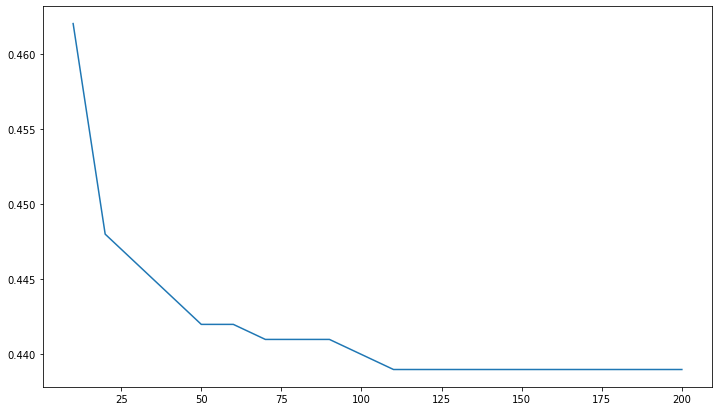

In [13]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.draw()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

After `n_estimators=120`, the RMSE stops improving.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [14]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((d, n, rmse.round(3)))

In [15]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

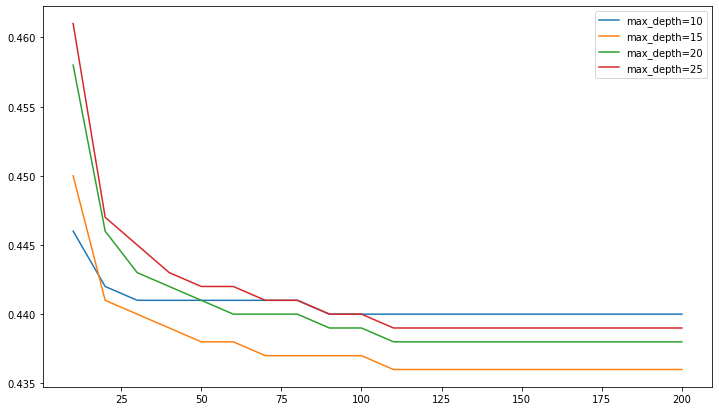

In [16]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
plt.legend()
plt.draw()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Best `max_depth` is 15. The answer will not be different if we change the seed of the model.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [17]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
importances = rf.feature_importances_
importances

array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

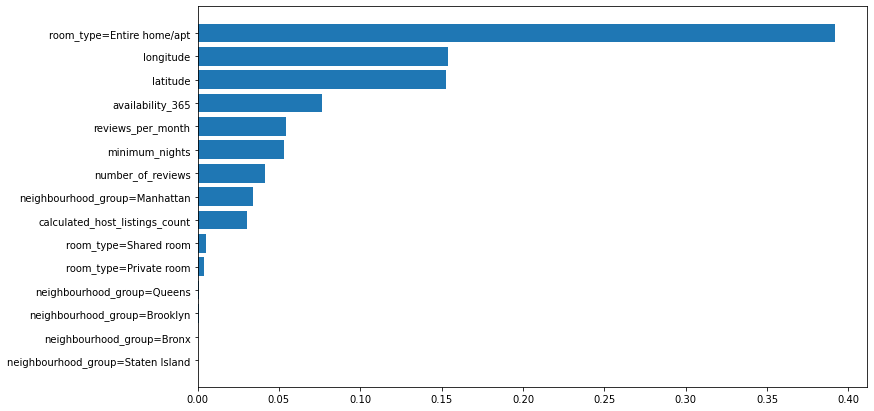

In [19]:
# Let's draw the importance in a plot for better understanding
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(dv.get_feature_names_out()[indices])

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

`room_type=Entire home/apt` is the most important feature.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [20]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Now change `eta` first to `0.1` and then to `0.01`

In [21]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [22]:
scores = []
for eta in [0.01, 0.1, 0.3]:
    print('{} eta={} {}'.format('-'*20, eta, '-'*20))
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

    y_pred = model.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append((eta, rmse.round(3)))
    print()

-------------------- eta=0.01 --------------------
[0]	train-rmse:4.25336	val-rmse:4.25010
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84921
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.49030	val-rmse:3.48719
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16029
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86533
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59925
[55]	train-rmse:2.47865	val-rmse:2.47612
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24835
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04514	val-rmse:2.04311
[80]	train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045

-------------------- eta=0.1 --------------------
[0]	train-rmse:3.87217	val-rmse:3.86889

In [23]:
scores

[(0.01, 1.63), (0.1, 0.432), (0.3, 0.436)]

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

`eta=0.1` leads to the best RMSE score on the validation dataset.